# Traffic Sign Classifier

In this notebook, I design a deep learning model to recognize traffic signs from the German Traffic Sign Dataset. The model, similar to AlexNet is 5 convolutional layers followed by 2 fully connected layers.  The dataset used is a subset of [_The German Traffic Sign Detection Benchmark_.](http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset) provided by Udacity.

---
### Loading Data

In [1]:
import pickle
import numpy as np

#
# Three files of pickled image data were provided
#
# The pickled data is a dictionary with 4 key/value pairs:
# - 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
# - 'labels' is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
# - 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
# - 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

training_file   = "../data/train.p"
validation_file = "../data/valid.p"
testing_file    = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test['features'],  test['labels']

In [2]:
#
# Generate a label map.  This allows us to map an integer 
# to the actual text name of the sign
#
label_map = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('int8'), ('S50')],  delimiter=',')

def label_lookup(x):
    if x >= 0 and x <= len(label_map):
        return label_map[x][1].decode("utf-8") 
    else:
        return "UNKNOWN"


---

### Dataset Summary & Exploration

The pickled files provided contained a total of 51839 examples taked from the German traffic sign dataset.  Training and Validation together make up roughly 75% of the total. About 25% of the examples are reserved for testing.  All examples are 32x32 in size and spread across 43 classes.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n_train      = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test       = X_test.shape[0]
image_shape  = X_train.shape[1:3]
n_classes    = np.unique(y_train).shape[0]
n_total      = n_train+n_validation+n_test
p_training   = n_train/n_total
p_validation = n_validation/n_total
p_test       = n_test/n_total


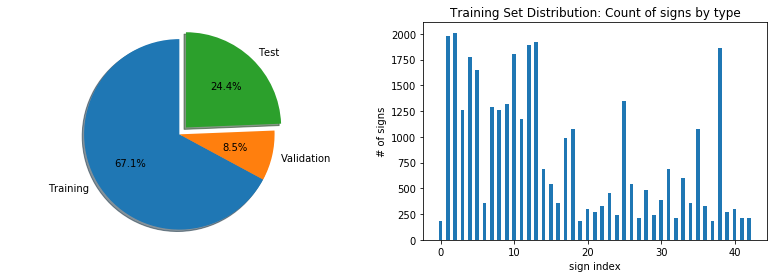

Total examples = 51839
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
#
# Pie chart of the Training, Validation, Test split
#
labels = 'Training', 'Validation', 'Test'
sizes = [p_training, p_validation, p_test]
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots(1, 2, figsize = (12, 4))
ax1[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1[0].axis('equal') 

#
# Bar chart showing the bincount 
# of each type of sign
#
x_axis = np.sort(np.unique(y_train))
sign_count = np.bincount(np.sort(y_train))
ax1[1].bar(x_axis, sign_count, 0.5)
ax1[1].set_title('Training Set Distribution: Count of signs by type')
ax1[1].set_ylabel('# of signs')
ax1[1].set_xlabel('sign index')
plt.subplots_adjust(right=1,  wspace=0.2)
plt.show()

print("Total examples =", n_total)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

---
### Random Sample of the Dataset

Below we see a random sample of the training dataset.  Although all examples are 32x32 pixels square, they are of differing illumination and signs in the images are not all the same size and shape. 

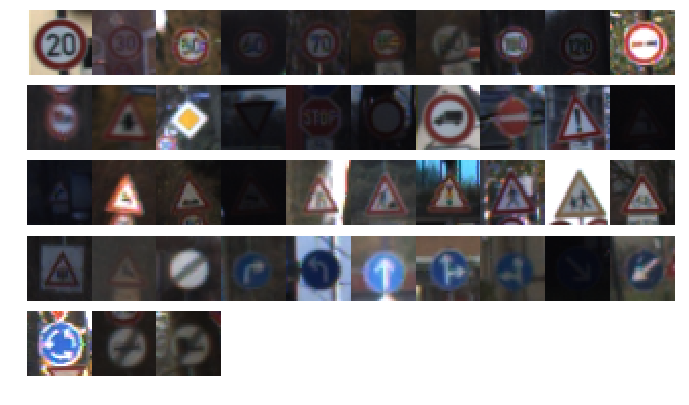

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_images = []
for i in range(n_classes):
    for j in range(len(X_train)):
        if y_train[j] == i:
            sample_images.append(X_train[j])
            break
    
fig, axes = plt.subplots(5, 10, figsize=(12, 6))
for a in axes.ravel():
    a.axis('off')
    
for j in range(len(sample_images)):
    row = int(j/10)
    col = j - (row * 10)
    axes[row][col].imshow(sample_images[j])
        
plt.subplots_adjust(left=0.0, right=.75, bottom=0.01, wspace=0.0, hspace=0.01)
plt.show()
plt.close(fig)


---
### Pre-processing of the Data Set

Several pre-processing techniques were attempted.  Among these were converting to YUV color space, just the Y channel [[1]](#ref_1), Local Contrast Normalization[[2]](#ref_2), and simple RGB color data.  In the end I found the best results with grayscale.  Image data is then normalized so that the data has mean zero and equal variance.  The mean is subtracted from each pixel and the result is divided by the standard deviation.  All values are then shifted to be between 0 and 1

In addition to grayscale data, a large increase in validation accuracy was obtained by augmenting the dataset by scaling, translating, and rotating existing images.  Random scaling was performed to 0.9 and 1.1 times the original size, translation of +/- 2 pixels in the x and y directions, and random rotation between -15 and 15 degrees.  Values were obtained from [[1]](#ref_1).  During data augmentation the uneven distribution of the training set was addressed.  The number of examples generated was calculated such that all sign types had even distribution.  Augmenting all classes to 1.5 times the count of the maximum class brings the training set up to nearly 130K examples.

Number of training examples = 129631
Number of testing examples = 12630
Image data shape = (129631, 32, 32, 1)
Number of classes = 43


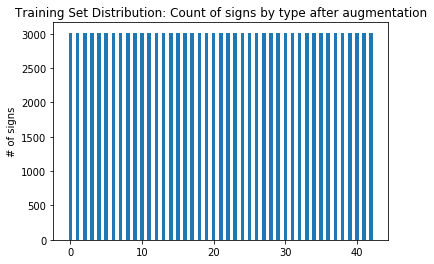

In [6]:
import random
import cv2

#
# The count of each sign type is increased to 1.5 times the 
# amount of the sign with the highest count.
#
aug_factor = 1.5
augments = np.float32(((np.max(sign_count) * aug_factor) - sign_count)/sign_count)

#
# Normalization.  I subtract the mean from each value and 
# divide by the standard deviation. Values are then shifted 
# to be between 0 and 1.
#
def normalize(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_min = (np.min(x) - x_mean) / x_std
    x_max = (np.max(x) - x_mean) / x_std
    x_norm = (((x.astype(np.float32) - x_mean) / x_std) - x_min) * 1/(x_max - x_min)
    return x_norm

def convert_to_grayscale(x):
    gray = x * (0.2989, 0.5870, 0.1140)
    gray = np.sum(gray, axis = 3).reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    return gray

def preprocess_images(x):
    #
    # Convert the original images to grayscale
    #
    x_gray = convert_to_grayscale(x)

    #
    # Normalize the data so all are 
    # between 0 and 1
    #
    return normalize(x_gray)


def augment_dataset(x, y):
    augment_tally = np.zeros_like(augments)
    augmented = []
    augmentedLabels = []
    for i in range(len(x)):
        label = y[i]
        
        augment_tally[label] += augments[label]
        number_to_augment = np.int8(augment_tally[label])
        augment_tally[label] -= number_to_augment
        
        for j in range(number_to_augment):
            img = x[i].copy()

            #
            # Scale the image. Use a random scaling
            # factor between .9 and 1.1
            #
            rows, cols = img.shape[:2]
            scale_factor = random.uniform(.9, 1.1)
            interpolation = cv2.INTER_LINEAR
            if scale_factor < 1.0:
                interpolation = cv2.INTER_AREA
            dst = cv2.resize(img, (int(scale_factor*cols), int(scale_factor*rows)), interpolation = interpolation)
            if scale_factor < 1.0:
                img = cv2.resize(dst, (img.shape[1], img.shape[0]), interpolation = interpolation)            
            else:
                img = dst[:32, :32]

            #
            # Translate the image a random amount 
            # between -2 and 2 pixels in the x and
            # y directions
            #
            x_trans = random.uniform(-2, 2)
            y_trans = random.uniform(-2, 2)
            M = np.float32([[1, 0, x_trans],[0, 1, y_trans]])
            img = cv2.warpAffine(img,M,(cols,rows))

            #
            # Rotate the image. Use a random angle
            # between -15 and 15 degrees.
            #
            angle = random.uniform(-15, 15)
            M = cv2.getRotationMatrix2D(((cols-1)/2.0, (rows-1)/2.0), angle, 1)
            img = cv2.warpAffine(img, M, (cols,rows))

            #
            # Add the new image and its label to the augmented list
            #
            augmented.append(img)
            augmentedLabels.append(label)
        
    return augmented, augmentedLabels

x_augmented, y_augmented = augment_dataset(X_train, y_train)
X_train = np.concatenate((X_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))
            
X_train = preprocess_images(X_train)
X_valid = preprocess_images(X_valid)
X_test  = preprocess_images(X_test)

input_channels = X_train.shape[3]

print("Number of training examples =", X_train.shape[0])
print("Number of testing examples =", X_test.shape[0])
print("Image data shape =", X_train.shape)
print("Number of classes =", np.unique(y_train).shape[0])

# numpy bincount to count occurances of each type of sign
x_axis = np.sort(np.unique(y_train))
sign_count = np.bincount(np.sort(y_train))
p1t = plt.bar(x_axis, sign_count, 0.5)
plt.ylabel('# of signs')
plt.title('Training Set Distribution: Count of signs by type after augmentation')
plt.show()



---
### Visualization of a sample of data augmentation

In the below visualazation we see the original sign at the beginning of the list and eight examples generated from it. 

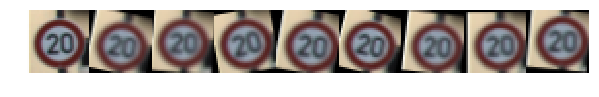

In [7]:
sample_aug = np.array([sample_images[0]])
sample_aug_labels = np.zeros(shape=(1,), dtype=np.int8)
augments = [8]
a, l = augment_dataset(sample_aug, sample_aug_labels)

sample_aug = np.concatenate((sample_aug, a))
set_labels = np.concatenate((sample_aug_labels, l))


fig, axes = plt.subplots(1, len(sample_aug), figsize=(12, 6))
for i in range(len(sample_aug)):
       axes[i].axis('off') 
       axes[i].imshow(sample_aug[i])

        
plt.subplots_adjust(left=0.1, right=.75, bottom=0.0, wspace=0.0, hspace=0.0)
plt.show()


----

## Design and Test a Model Architecture

Design and implemention went through many iterations. The process of determining the correct layers, kernel sizes, strides, etc., feels to be a largely empirical process.  LeNet-5 was used as a starting point and provided validation accuracy around 88%.  Following Sermanet and LeCun[[1]](#ref_1), I achieved over 95% validation accuracy by feeding grayscale images to a 2 layer convolution neural network followed by 2 fully connected layers with the output of both convolutional layers concatenated and fed into the fully connected layers. 

Attempting to achieve even better accuracy, I added an Inception layer to the modified LeNet.  Although training time increased significantly, accuracy did not.  After many iterations and training time I finally decided upon a model much like AlexNet[[3]](#ref_3) though modified to have a smaller number of parameters.  Final validation accuracy was 99.3%

There were several aspects of the architecture that had large effects on validation accuracy or convergence.  The first was the augmentation of the dataset.  This provided a noticeable jump in accuracy across all models.  Another was the learning rate.  A small change in the learning rate can have a big difference on the time it took for a model to reach top accuracy.  In some cases an incorrect learning rate would keep the network from converging at all. I tried several different optimizers, with and without learning rate decay, and found that AdamOptimizer worked best for this situation.  The Number of epochs varied across models.  The deeper models with more layers required more epochs to reach their maximum accuracy. 

### Model Architecture

In [8]:
import tensorflow as tf

def weights_and_biases(shape, name):
    mu = 0
    sigma = 0.1
    w = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma), name = name + "_weights")
    b = tf.Variable(tf.zeros(shape[-1]), name = name + "_biases")
    return w, b

def conv2d(x, shape, name, stride = 1, padding='VALID'):
    weights, biases = weights_and_biases((shape), name)
    layer = tf.nn.conv2d(x, weights, [1, stride, stride, 1], padding=padding)
    layer = tf.nn.bias_add(layer, biases)
    layer = tf.nn.relu(layer)
    return layer

def fc(x, shape, name):
    weights, biases = weights_and_biases((shape), name)
    fc_layer = tf.add(tf.matmul(x, weights), biases)
    return fc_layer

visualize_conv_layer = None
def csharpNet(x):
    global visualize_conv_layer
    
    #
    # First Convolutional layer
    # Input  = 32x32x1
    # Output = 30x30x32
    #
    conv1 = conv2d(x, (3, 3, 1, 32), "conv1")

    #
    # Second Convolutional layer
    # Input  = 30x30x32
    # Output = 28x28x60
    #
    conv2 = conv2d(conv1, (3, 3, 32, 60), "conv2")

    #
    # Max Pooling and Dropout
    # Input  = 28x28x60
    # Output = 14x14x60.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob = keep_prob)
    visualize_conv_layer = conv2

    #
    # Third Convolutional layer
    # Input  = 14x14x60
    # Output = 12x12x75
    #
    conv3 = conv2d(conv2, (3, 3, 60, 75), "conv3")

    #
    # Fourth Convolutional layer
    # Input  = 12x12x75
    # Output = 5x5x100
    #
    conv4 = conv2d(conv3, (3, 3, 75, 100), "conv4")
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob = keep_prob)

    #
    # Fifth Convolutional layer
    # Input  = 5x5x100
    # Output = 3x3x125
    #
    conv5 = conv2d(conv4, (3, 3, 100, 125), "conv5")

    #
    # Flatten.
    # Input  = 3x3x125
    # Output = 1125
    #
    flat = tf.contrib.layers.flatten(conv5)

    #
    # Fully Connected 1:
    # Input  = 1125
    # Output = 1024
    #
    fc1 = fc(flat, (1125, 1024), "fc1")
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob = keep_prob)

    #
    # Fully Connected 2:
    # Input  = 1024
    # Output = 43
    #
    logits = fc(fc1, (1024, 43), "fc2")
    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
#
# TF Placeholders.
# - Keep_prob is used for dropout
# - x is the image training data
# - y is the image training data's labels
#
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, input_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)


EPOCHS        = 40
BATCH_SIZE    = 128
LEARNING_RATE = 1e-4

logits = csharpNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [10]:
from sklearn.utils import shuffle
import time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training {} examples, {} epochs....".format(num_examples, EPOCHS))
    total_time_start = time.time()
    for i in range(EPOCHS):
        epoch_start = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        epoch_end = time.time()
        print("EPOCH {:2d} ({:2d} secs): {:.3f}  {:.3f}".format(i+1, int(epoch_end-epoch_start), training_accuracy, validation_accuracy))

    saver.save(sess, './csharpNet')
    print("Model saved")
    total_time_end = time.time()
    print("Total training time: " + str(int(total_time_end - total_time_start)) + " seconds")


Training 129631 examples, 40 epochs....
EPOCH  1 (49 secs): 0.199  0.202
EPOCH  2 (46 secs): 0.710  0.743
EPOCH  3 (46 secs): 0.857  0.885
EPOCH  4 (46 secs): 0.922  0.944
EPOCH  5 (46 secs): 0.949  0.953
EPOCH  6 (46 secs): 0.966  0.965
EPOCH  7 (46 secs): 0.977  0.970
EPOCH  8 (46 secs): 0.983  0.975
EPOCH  9 (46 secs): 0.986  0.978
EPOCH 10 (46 secs): 0.989  0.979
EPOCH 11 (46 secs): 0.992  0.979
EPOCH 12 (46 secs): 0.993  0.983
EPOCH 13 (46 secs): 0.994  0.984
EPOCH 14 (46 secs): 0.995  0.985
EPOCH 15 (46 secs): 0.996  0.985
EPOCH 16 (46 secs): 0.996  0.986
EPOCH 17 (46 secs): 0.997  0.986
EPOCH 18 (46 secs): 0.997  0.986
EPOCH 19 (46 secs): 0.998  0.985
EPOCH 20 (46 secs): 0.998  0.987
EPOCH 21 (46 secs): 0.998  0.990
EPOCH 22 (46 secs): 0.998  0.989
EPOCH 23 (46 secs): 0.999  0.991
EPOCH 24 (46 secs): 0.999  0.988
EPOCH 25 (46 secs): 0.998  0.990
EPOCH 26 (46 secs): 0.999  0.989
EPOCH 27 (46 secs): 0.999  0.990
EPOCH 28 (46 secs): 0.999  0.992
EPOCH 29 (46 secs): 0.999  0.990
EPO

### Test set accuracy

In [11]:
#
# Evaluate the trained model on the test set
#
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./csharpNet
Test Accuracy = 0.979


---

## Test a Model on New Images

I provided 7 signs found on the internet plus 2 signs from a video of a friend driving in the Czech Republic. I obtained 2 stop signs with differing lighting.  The smaller Road Work sign and the Prioirty Road sign are from roads in the Czech Republic but are nearly identical to the German counterparts.  

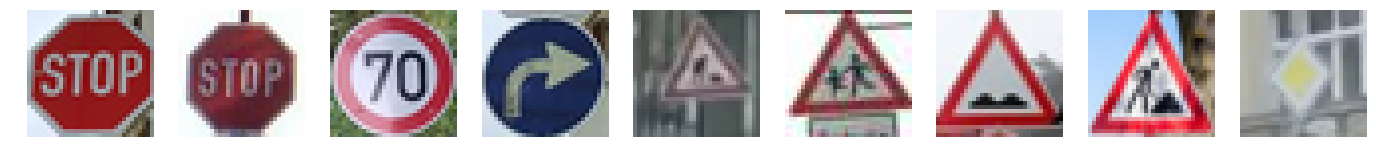

In [12]:
import os
import cv2

#
# Load the images from the test_images folder. 
# the signs list holds the image data and the labels list holds the 
# indices into the label_map for the correct type of sign
#
signs  = []
labels_dict = {'test_image1.jpg':4, 'test_image2.jpg':14, 'test_image3.jpg':22, 'test_image4.jpg':25, 'test_image5.jpg':14, 'test_image6.jpg':33, 'test_image7.png':25, 'test_image8.png':12, 'children.jpg':28}
labels = []
image_names = []
supported_image_files = [ ".jpg", ".jpeg", ".png"]
for image_name in os.listdir('test_images/'):
        base, ext = os.path.splitext(image_name)
        if (ext.lower() in supported_image_files):
            image_names.append('test_images/' + image_name)
            img = cv2.imread('test_images/' + image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            signs.append(img)
            labels.append(labels_dict[image_name])

fig, axes = plt.subplots(1, len(signs), figsize=(24, 3))
for i in range(len(signs)):
    axes[i].axis('off')
    axes[i].imshow(signs[i])

### Predict the Sign Type for Each Image

Below we can see the results of running the above images through preprocessing and the model.  Predictions from the network are shown in the title above the image. 

INFO:tensorflow:Restoring parameters from ./csharpNet
Overall accuracy for the 9 internet images = 1.000


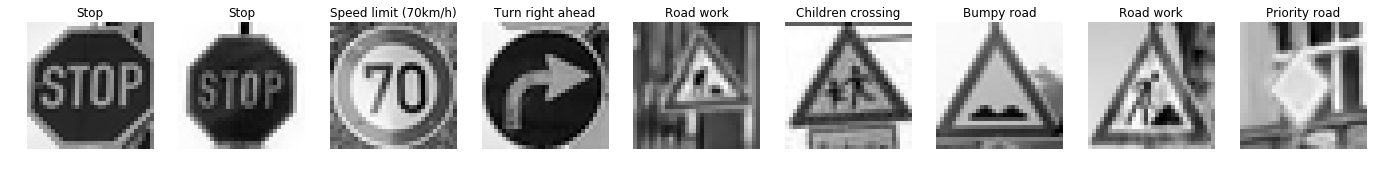

In [13]:

signs = np.array(signs, np.float32)
signs = preprocess_images(signs)

internet_predictions = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(internet_predictions, feed_dict={x: signs, y: [], keep_prob:1.0})
    internet_test_accuracy = evaluate(signs, labels)
    
fig, axes = plt.subplots(1, len(signs), figsize=(24, 3))
for i in range(len(signs)):
    img = signs[i].reshape((32, 32))
    axes[i].axis('off')
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('{}'.format(label_lookup(labels[i])))
                      
print("Overall accuracy for the {} internet images = {:.3f}".format(str(len(signs)), internet_test_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [14]:

top_k = tf.nn.top_k(tf.nn.softmax(logits), 5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_probs, softmax_indices = sess.run(top_k, feed_dict={x: signs, y: [], keep_prob: 1.0})


func = lambda i, j: label_lookup(softmax_indices[i][j]) + " <br> ({:0.1f}%)".format(softmax_probs[i][j] * 100)

softmax_labels = np.fromfunction(np.vectorize(func), softmax_indices.shape, dtype=int)
softmax_labels = np.transpose(softmax_labels)

img_tags = []
for image_name in image_names:
    img_tags.append('<div style=\"margin: auto; width: 64px\"> <img src=\"' + image_name + '\" height=\"64\" width=\"64\"/></div>')

tags = np.array([img_tags])
softmax_labels = np.insert(tags, 1, softmax_labels, 0)
from IPython.display import HTML, display
display(HTML('<table><tr>{}</tr></table>'.format('</tr><tr>'.join('<td style=\"text-align: center;\">{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in softmax_labels))))


INFO:tensorflow:Restoring parameters from ./csharpNet


,,,,,,,,
Stop (100.0%),Stop (100.0%),Speed limit (70km/h) (100.0%),Turn right ahead (99.7%),Road work (99.8%),Children crossing (100.0%),Bumpy road (99.9%),Road work (100.0%),Priority road (100.0%)
Yield (0.0%),Turn right ahead (0.0%),Speed limit (20km/h) (0.0%),Ahead only (0.2%),Road narrows on the right (0.2%),Right-of-way at the next intersection (0.0%),Bicycles crossing (0.1%),Road narrows on the right (0.0%),No vehicles (0.0%)
Speed limit (70km/h) (0.0%),Yield (0.0%),Speed limit (30km/h) (0.0%),No passing for vehicles over 3.5 metric tons (0.1%),Roundabout mandatory (0.0%),Road work (0.0%),Road work (0.0%),Right-of-way at the next intersection (0.0%),Speed limit (50km/h) (0.0%)
Turn right ahead (0.0%),Speed limit (60km/h) (0.0%),General caution (0.0%),Speed limit (80km/h) (0.0%),Dangerous curve to the right (0.0%),Beware of ice/snow (0.0%),Road narrows on the right (0.0%),Children crossing (0.0%),Yield (0.0%)
Speed limit (30km/h) (0.0%),Speed limit (70km/h) (0.0%),Traffic signals (0.0%),End of no passing by vehicles over 3.5 metric tons (0.0%),Go straight or left (0.0%),Wild animals crossing (0.0%),Priority road (0.0%),Ahead only (0.0%),Speed limit (30km/h) (0.0%)


---

## Visualize the Neural Network's State with Test Images

I visualize the second convolutional layer of my network using the global variable `visualize_conv_layer`.  This layer outputs the 60 feature maps you see below. Activations can be seen to match the triangular shape of the input image and the and road bumps at the bottom of the triangle. 

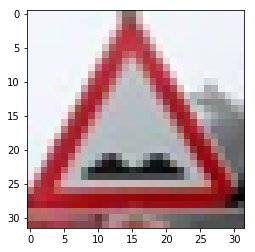

In [15]:
#
# The input image for visualizing layers.
#
img = cv2.imread('test_images/test_image3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

INFO:tensorflow:Restoring parameters from ./csharpNet


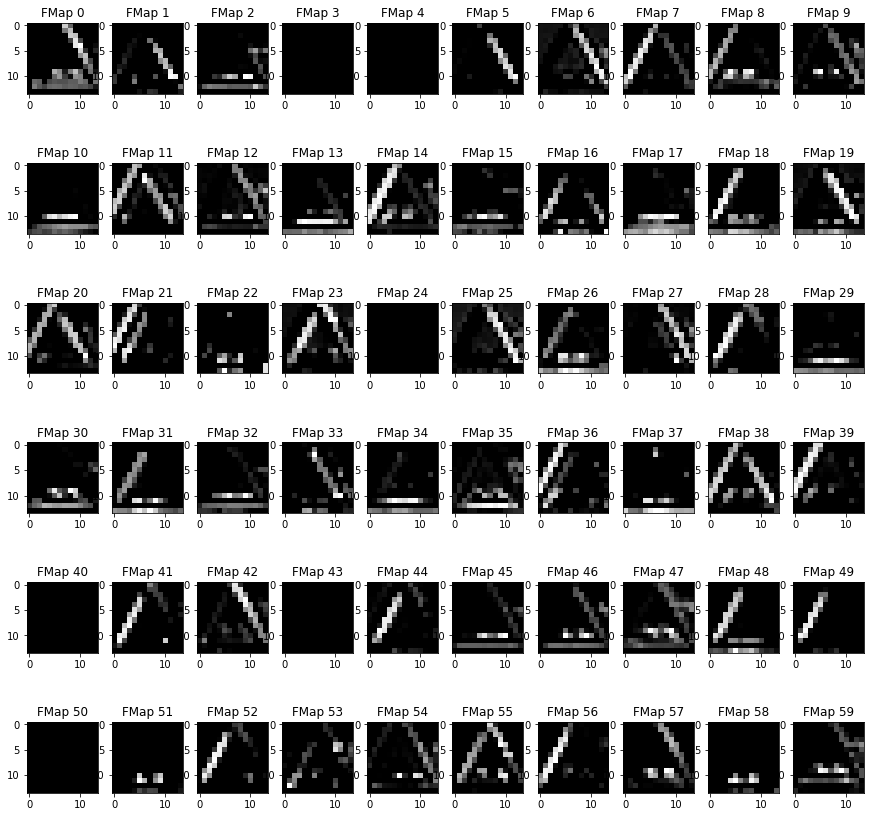

In [16]:

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input_list = np.array([image_input])
    image_input_list = preprocess_images(image_input_list)
    image_input = image_input_list
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, y : [], keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,10, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(img, visualize_conv_layer)

### References
<a id='ref_1'></a>[1] P. Sermanet and Y. LeCun. [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

<a id='ref_2'></a>[2] K. Jarrett, K. Kavukcuoglu, M. Ranzato and Y. LeCun [What is the Best Multi-Stage Architecture for Object Recognition?](http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf)

<a id='ref_3'></a>[3] A. Krizhevsky, I. Sutskever, G. Hinton [ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)